<a href="https://colab.research.google.com/github/teeokh/Bird-Call-Classifier/blob/main/bird_call_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install tensorflow-io
!pip install matplotlib

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [13]:
# Define the paths to the files

CAPUCHIN_FILE = os.path.join("/content/drive/MyDrive/Datasets/Bird_Call_Data" ,"Parsed_Capuchinbird_Clips", "XC3776-3.wav")
NON_CAPUCHIN_FILE = os.path.join("/content/drive/MyDrive/Datasets/Bird_Call_Data", "Parsed_Not_Capuchinbird_Clips", "afternoon-birds-song-in-forest-0.wav")


In [7]:
# Build function to load the data

# Loads and preprocesses the audio to resample into 16k SR, and into mono (1 channel)
def load_wav_16k_mono(filename):

  # Loads contents of audio file. This returns a string (file_contents)
  file_contents = tf.io.read_file(filename)

  # Decodes the audio file string, returning the audio array and the sample rate (decode_wav returns this as a tensor into 2 elements)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

  # Gets rid of trailing axis? And converts sample rate to an integer (so we can resample)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)

  # Resamples audio array to 16k SR
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

  return wav

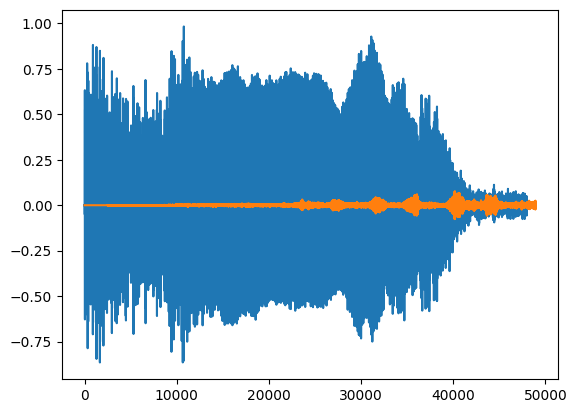

In [15]:
# Plot the waves

wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NON_CAPUCHIN_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()